In [1]:
from omegaconf import OmegaConf
from pathlib import Path
import pandas as pd
from multiprocessing import Pool
from carps.analysis.gather_data import add_scenario_type

config_folder = Path("../carps/configs/problem")
paths = list(config_folder.glob("**/*.yaml"))
paths = [p for p in paths if "DUMMY" not in str(p)]

def read_task(p) -> dict:
    cfg = OmegaConf.load(p)
    task = OmegaConf.to_container(cfg.task)
    task["benchmark_id"] = cfg.benchmark_id
    task["problem_id"] = cfg.problem_id
    return task

with Pool() as pool:
    tasks = pool.map(read_task, paths)
tasks = pd.DataFrame(tasks)
tasks["is_multiobjective"] = tasks["n_objectives"] > 1
tasks = add_scenario_type(tasks, task_prefix="")
print(tasks.columns)

Index(['n_trials', 'time_budget', 'n_workers', 'n_objectives', 'objectives',
       'is_multifidelity', 'fidelity_type', 'min_budget', 'max_budget',
       'has_constraints', 'domain', 'objective_function_approximation',
       'has_virtual_time', 'deterministic', 'dimensions',
       'search_space_n_categoricals', 'search_space_n_ordinals',
       'search_space_n_integers', 'search_space_n_floats',
       'search_space_has_conditionals', 'search_space_has_forbiddens',
       'search_space_has_priors', 'benchmark_id', 'problem_id',
       'is_multiobjective', 'scenario'],
      dtype='object')


In [54]:
import numpy as np
def is_subset(problem_id: str) -> bool:
    scenarios = ["blackbox", "multifidelity", "multiobjective", "momf"]
    return np.any([problem_id.startswith(s) for s in scenarios])

def add_set_id(problem_id: str) -> str:
    if "dev" in problem_id:
        return "dev"
    elif "test" in problem_id:
        return "test"
    else:
        raise ValueError(f"Can't determine set for problem_id {problem_id}.")

subselections = tasks[tasks["problem_id"].map(is_subset)]
subselections["set"] = subselections["problem_id"].map(add_set_id)

cols_general = ["benchmark_id", "problem_id", "dimensions", "n_trials",  "search_space_n_floats", "search_space_n_integers", "search_space_n_categoricals", "search_space_n_ordinals"]
cols_MF = ["fidelity_type", "min_budget", "max_budget",]
cols_MO = ["n_objectives"]


for pid, pset in subselections.groupby(by=["scenario", "set"]):
    cols = cols_general.copy()
    if pid[0] == "multi-fidelity":
        cols += cols_MF
    elif pid[0] == "multi-objective":
        cols += cols_MO
    elif pid[0] != "blackbox":
        cols += cols_MF
        cols += cols_MO
    pset = pset[cols]
    latex_str = pset.to_latex(index=False, caption="Selected tasks " + str(pid), label=f"tab:selectedtasks{pid}", float_format="%.2f")
    latex_str = latex_str.replace("problem_id", "task")
    latex_str = latex_str.replace("search_space_", "")
    latex_str = latex_str.replace("_", "\_")
    latex_str = latex_str.replace(r"\begin{tabular}", "\centering\n\\resizebox{\\textwidth}{!}{\\begin{tabular}")
    latex_str = latex_str.replace(r"\end{tabular}", "\\end{tabular}}")
    fn = Path("tables") / f"selected_tasks_{pid}.tex"
    fn.parent.mkdir(exist_ok=True, parents=True)
    fn.write_text(latex_str)
    print(latex_str)

/tmp/ipykernel_2028185/1451468861.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subselections["set"] = subselections["problem_id"].map(add_set_id)


\begin{table}
\caption{Selected tasks ('blackbox', 'dev')}
\label{tab:selected\_tasks\_('blackbox', 'dev')}
\centering
\resizebox{\textwidth}{!}{\begin{tabular}{llrrrrrr}
\toprule
benchmark\_id & task & dimensions & n\_trials & n\_floats & n\_integers & n\_categoricals & n\_ordinals \\
\midrule
YAHPO & blackbox/30/dev/yahpo/rbv2\_ranger/41142/None & 8 & 134 & 2 & 3 & 3 & 0 \\
HPOB & blackbox/30/dev/hpob/all/6766/9967 & 2 & 100 & 2 & 0 & 0 & 0 \\
HPOB & blackbox/30/dev/hpob/all/5891/145677 & 8 & 100 & 8 & 0 & 0 & 0 \\
BBOB & blackbox/30/dev/bbob/noiseless/2/2/2 & 2 & 77 & 2 & 0 & 0 & 0 \\
HPOBench & blackbox/30/dev/hpobench/bb/tab/ml/svm/167120 & 2 & 77 & 0 & 0 & 0 & 2 \\
HPOB & blackbox/30/dev/hpob/all/5891/9976 & 8 & 100 & 8 & 0 & 0 & 0 \\
HPOB & blackbox/30/dev/hpob/all/6766/145847 & 2 & 100 & 2 & 0 & 0 & 0 \\
HPOB & blackbox/30/dev/hpob/all/6767/3913 & 18 & 100 & 18 & 0 & 0 & 0 \\
HPOB & blackbox/30/dev/hpob/all/2010/125966 & 8 & 100 & 8 & 0 & 0 & 0 \\
HPOB & blackbox/30/dev/hpob/al

In [2]:
def print_cat(x):
    print(x.name)
    print(x["search_space_n_categoricals"].sum())

tasks.groupby(by=["benchmark_id"]).apply(print_cat)

BBOB
0
HPOB
0
HPOBench
0
MFPBench
0
Pymoo
0
YAHPO
6689


/tmp/ipykernel_2028185/819669217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tasks.groupby(by=["benchmark_id"]).apply(print_cat)


""


In [3]:
print("number of all problems", len(tasks))
print("number of benchmarks", tasks["benchmark_id"].nunique())
for gid, gdf in tasks.groupby("scenario"):
    print(gid, len(gdf))

number of all problems 5443
number of benchmarks 6
blackbox 3348
multi-fidelity 1897
multi-fidelity-objective 53
multi-objective 145


In [4]:
list(tasks.columns)

['n_trials',
 'time_budget',
 'n_workers',
 'n_objectives',
 'objectives',
 'is_multifidelity',
 'fidelity_type',
 'min_budget',
 'max_budget',
 'has_constraints',
 'domain',
 'objective_function_approximation',
 'has_virtual_time',
 'deterministic',
 'dimensions',
 'search_space_n_categoricals',
 'search_space_n_ordinals',
 'search_space_n_integers',
 'search_space_n_floats',
 'search_space_has_conditionals',
 'search_space_has_forbiddens',
 'search_space_has_priors',
 'benchmark_id',
 'problem_id',
 'is_multiobjective',
 'scenario']

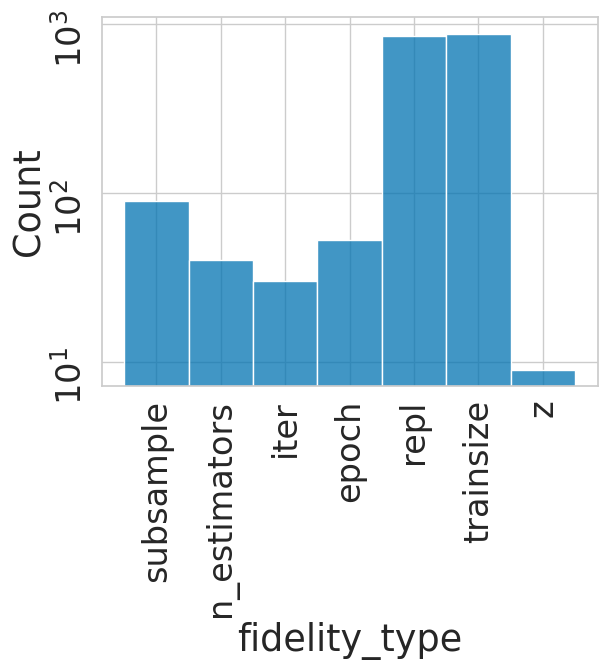

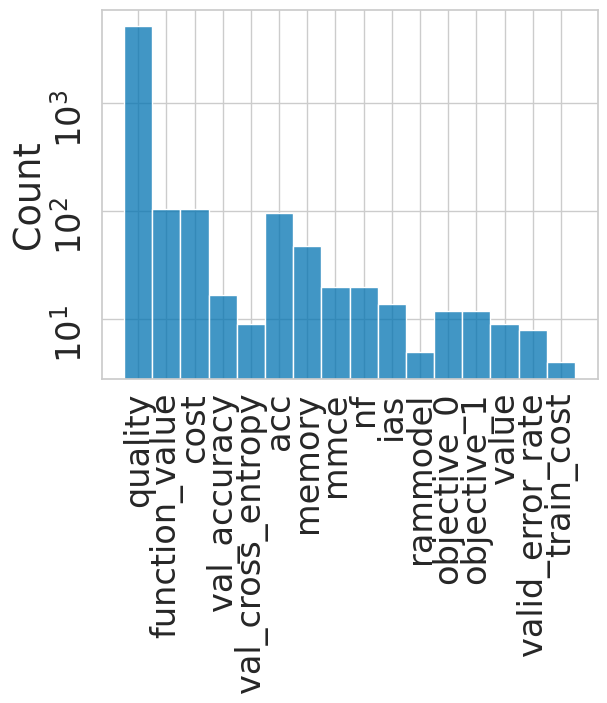

5443


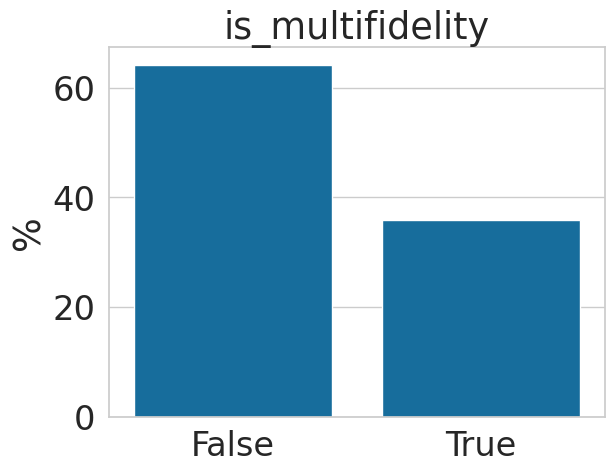

[08:36:12] INFO     Using categorical units to plot a list of strings that are all parsable as      ]8;id=403408;file:///scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=778028;file:///scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/matplotlib/category.py#223\223]8;;\
                    floats or dates. If these strings should be plotted as numbers, cast to the                    
                    appropriate data type before plotting.                                                         

           INFO     Using categorical units to plot a list of strings that are all parsable as      ]8;id=127750;file:///scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=437496;file:///scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/matplotlib/category.py#223\223]8;;\
                    floats or dates. If these strings should be plotted as numbers, cast to the                    
                    appropriate data type before plotting.                                                         

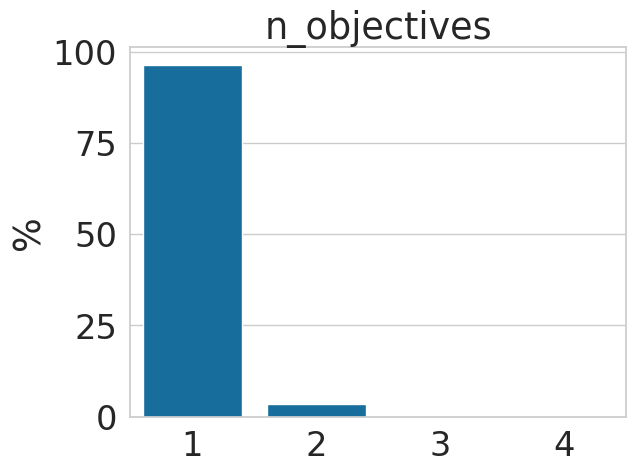

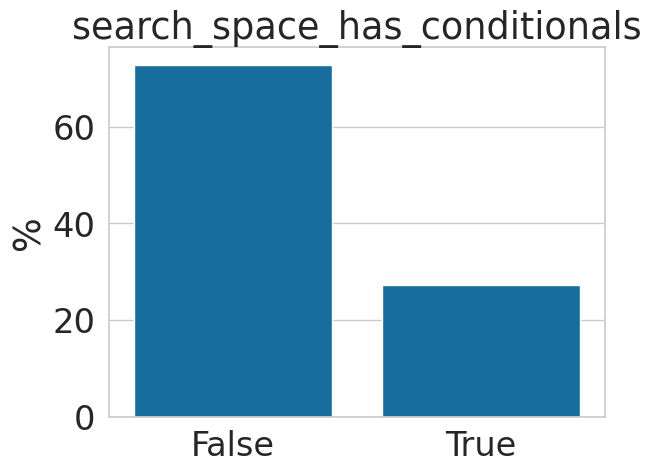

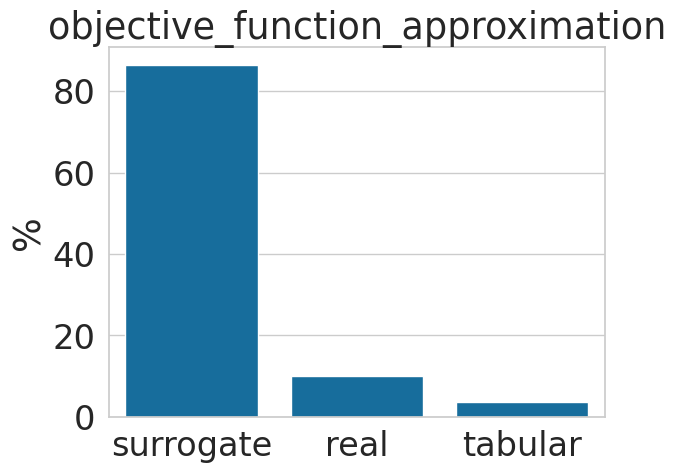

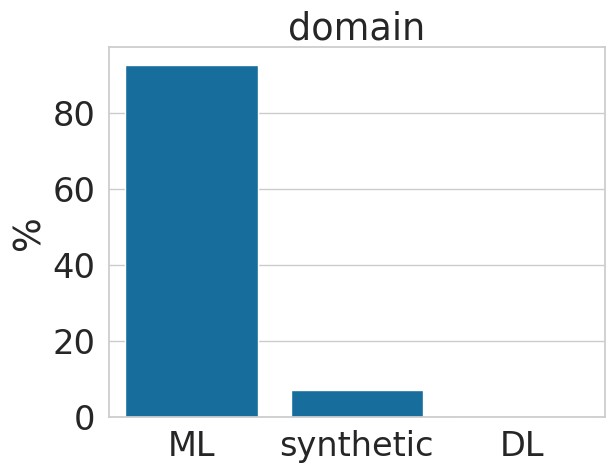

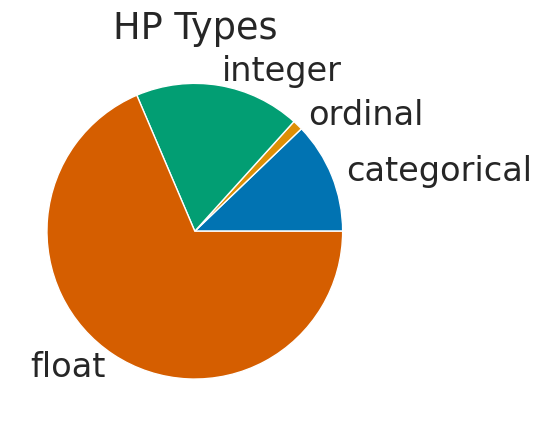

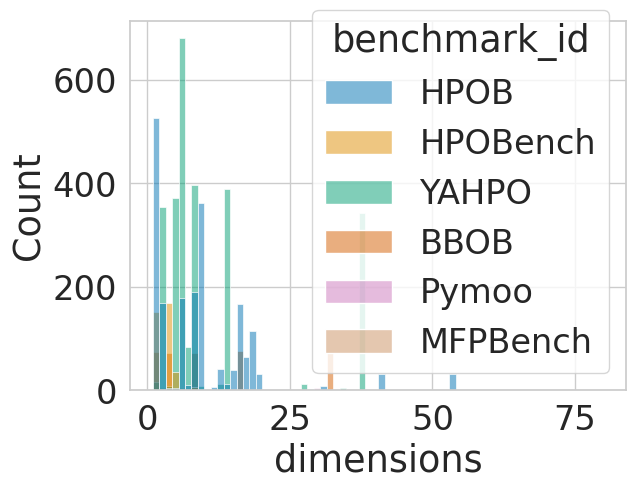

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sns.set(font_scale=2.2)
sns.set_style("whitegrid")
sns.set_palette("colorblind")




n_multiobjective = np.sum(tasks["n_objectives"] > 1)
n_multifidelity = np.sum(~tasks["fidelity_type"].isna())
n_conditional_search_spaces = np.sum(tasks["search_space_has_conditionals"])
n_tasks = len(tasks)


def make_pie(n: int, total: int, identifier: str):
    fig, ax = plt.subplots()
    sizes = [int(n), int(total - n)]
    labels = [f"{identifier} ({n*100/total:.0f}%)", "total"]
    ax.pie(sizes, labels=labels)
    plt.show()


def savefig(fnbase: str, fig):
    extensions = [".pdf", ".png"]
    for extension in extensions:
        fn = Path(fnbase + extension)
        fn.parent.mkdir(exist_ok=True, parents=True)
        fig.savefig(fn, dpi=300, bbox_inches="tight")


def plot_pie_value_counts(tasks: pd.DataFrame, key_column: str):
    fig, ax = plt.subplots()
    value_counts = tasks[key_column].value_counts()
    sizes = value_counts.values / np.sum(value_counts.values) * 100
    labels = list(value_counts.index)
    ax = sns.barplot(x=labels, y=sizes, ax=ax)
    ax.set_ylabel("%")
    ax.set_title(key_column)
    savefig(f"figures/benchmarks/pie_{key_column}", fig)
    plt.show()

def plot_pie_hp_types(tasks: pd.DataFrame):
    fig, ax = plt.subplots()
    sizes = [tasks["search_space_n_categoricals"].sum(), tasks["search_space_n_ordinals"].sum(), tasks["search_space_n_integers"].sum(), tasks["search_space_n_floats"].sum()]
    labels = ["categorical", "ordinal", "integer", "float"]
    ax.pie(sizes, labels=labels)
    ax.set_title("HP Types")
    savefig(f"figures/benchmarks/pie_HPtypes", fig)
    plt.show()

def plot_dimensions(tasks: pd.DataFrame):
    fig, ax = plt.subplots()
    sns.histplot(data=tasks, x="dimensions", hue="benchmark_id")
    savefig(f"figures/benchmarks/histogram_dimensions", fig)
    plt.show()



ax = sns.histplot(data=tasks, x="fidelity_type")
ax.tick_params(rotation=90)
ax.set_yscale("log")
plt.show()
objectives = np.concatenate(tasks["objectives"][tasks["objectives"].apply(lambda x: x is not None)])
ax = sns.histplot(objectives)
ax.tick_params(rotation=90)
ax.set_yscale("log")
plt.show()
print(n_tasks)
plot_pie_value_counts(tasks=tasks, key_column="is_multifidelity")
plot_pie_value_counts(tasks=tasks, key_column="n_objectives")
plot_pie_value_counts(tasks=tasks, key_column="search_space_has_conditionals")
plot_pie_value_counts(tasks=tasks, key_column="objective_function_approximation")
plot_pie_value_counts(tasks=tasks, key_column="domain")
plot_pie_hp_types(tasks)
plot_dimensions(tasks)



